# **Benchmark** **Dataset**

## Prepare Data and Notebook

In [ ]:
!pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 75.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 89.2 MB/s eta 0:00:00


In [ ]:
import geopandas
import pandas as pd
import seaborn as sns
import math
import matplotlib.pyplot as plt
import warnings
import numpy as np
import statistics
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.metrics import roc_auc_score
import tensorflow as tf

warnings.filterwarnings("ignore", module = "matplotlib\..*")
# Hide VisibleDeprecationWarning

In [ ]:
!wget https://geomorphology.irpi.cnr.it/tools/slope-units/slope-units-map/dataset_benchmark.zip
!unzip dataset_benchmark.zip

--2023-01-10 08:49:38--  https://geomorphology.irpi.cnr.it/tools/slope-units/slope-units-map/dataset_benchmark.zip
Resolving geomorphology.irpi.cnr.it (geomorphology.irpi.cnr.it)... 194.119.218.58
Connecting to geomorphology.irpi.cnr.it (geomorphology.irpi.cnr.it)|194.119.218.58|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21577787 (21M) [application/zip]
Saving to: ‘dataset_benchmark.zip’

dataset_benchmark.z 100%[===================>]  20.58M  1.50MB/s    in 19s     

2023-01-10 08:49:58 (1.06 MB/s) - ‘dataset_benchmark.zip’ saved [21577787/21577787]

Archive:  dataset_benchmark.zip
   creating: dataset_benchmark/
  inflating: dataset_benchmark/README.txt  
  inflating: dataset_benchmark/README.txt~  
   creating: dataset_benchmark/su_benchmark/
  inflating: dataset_benchmark/su_benchmark.csv  
  inflating: dataset_benchmark/su_benchmark.gpkg  
  inflating: dataset_benchmark/su_benchmark/su_benchmark.dbf  
  inflating: dataset_benchmark/su_benchmark/su_be

In [ ]:
!wget https://idrogeo.isprambiente.it/opendata/frane/frane_piff_umbria_opendata.zip
!unzip frane_piff_umbria_opendata.zip

--2023-01-10 08:49:59--  https://idrogeo.isprambiente.it/opendata/frane/frane_piff_umbria_opendata.zip
Resolving idrogeo.isprambiente.it (idrogeo.isprambiente.it)... 193.206.192.71
Connecting to idrogeo.isprambiente.it (idrogeo.isprambiente.it)|193.206.192.71|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1615173 (1.5M) [application/zip]
Saving to: ‘frane_piff_umbria_opendata.zip’

frane_piff_umbria_o 100%[===================>]   1.54M  2.24MB/s    in 0.7s    

2023-01-10 08:50:00 (2.24 MB/s) - ‘frane_piff_umbria_opendata.zip’ saved [1615173/1615173]

Archive:  frane_piff_umbria_opendata.zip
  inflating: frane_piff_opendataPoint.prj  
  inflating: frane_piff_opendataPoint.shp  
  inflating: wfsrequest.txt          
  inflating: frane_piff_opendataPoint.shx  
  inflating: frane_piff_opendataPoint.dbf  
  inflating: frane_piff_opendataPoint.cst  


In [ ]:
def get_point_biserial_correlation(gdf, cont, discrete):
  true_list = gdf[cont][gdf[discrete]==1].to_list()
  false_list = gdf[cont][gdf[discrete]==0].to_list()
  true_count = len(true_list)
  false_count = len(false_list)
  total_count = true_count + false_count

  true_mean = statistics.mean(true_list)
  false_mean = statistics.mean(false_list)

  total_list = [*true_list, *false_list]
  total_sd = statistics.stdev(total_list)
  pb = ((true_mean - false_mean) / total_sd) * math.sqrt((true_count*false_count)/total_count**2)
  print(f"Point-biserial correlation of {discrete} and {cont} = {pb}")
  fig, ax = plt.subplots()
  plt.title(f"Point-biserial correlation of {discrete} and {cont} = {round(pb, 4)}")
  plt.ylabel(cont)
  ax.boxplot((true_list, false_list))
  ax.set_xticklabels((
      f"{discrete} = 1 \n Avg. {cont}: {round(true_mean, 4)}",
      f"{discrete} = 0 \n Avg. {cont}: {round(false_mean, 4)}"))

In [ ]:
def plot_x_y_discrete(gdf, x, y, discrete):
  select1 = gdf[[discrete, x, y]][gdf[discrete]==1]
  select0 = gdf[[discrete, x, y]][gdf[discrete]==0]
  plt.xlabel(x)
  plt.ylabel(y)
  plt.scatter(select1[x], select1[y], s=1, label="SU with landslides")
  plt.scatter(select0[x], select0[y], s=1, label="SU without landslides")
  plt.legend()

In [ ]:
def calc_auc(x, y):
    auc = 0
    for i in range(1, len(x)):
        auc+=(x[i]-x[i-1])*y[i] - ((x[i]-x[i-1])*(y[i]-y[i-1])/2)      
    return auc

## Overview - Data visualization

In [ ]:
gdf = geopandas.read_file("dataset_benchmark/su_benchmark/su_benchmark.shp")
gdf.columns

Index(['id', 'slope_aver', 'slope_stdd', 'pcurv_aver', 'pcurv_stdd',
       'tcurv_aver', 'tcurv_stdd', 'nthns_aver', 'nthns_stdd', 'easns_aver',
       'easns_stdd', 'elev_avera', 'elev_stdde', 'twi_averag', 'twi_stddev',
       'BDRICM_ave', 'BDRICM_std', 'BLDFIE_ave', 'BLDFIE_std', 'CLYPPT_ave',
       'CLYPPT_std', 'SLTPPT_ave', 'SLTPPT_std', 'SNDPPT_ave', 'SNDPPT_std',
       'Max_Distan', 'D_sqrt_A', 'presence1', 'presence2', 'area', 'geometry'],
      dtype='object')

In [ ]:
gdf["presence1"].value_counts()[1] # SU with LS

3594

In [ ]:
selection_p1 = gdf[['presence1','slope_aver', 'elev_avera',
       'BDRICM_ave', 'BLDFIE_ave', 'CLYPPT_ave', 'SLTPPT_ave', 'SNDPPT_ave',
       'Max_Distan', 'D_sqrt_A', 'area']]

## Variables Pair-Plots

Joint distribution pair plots

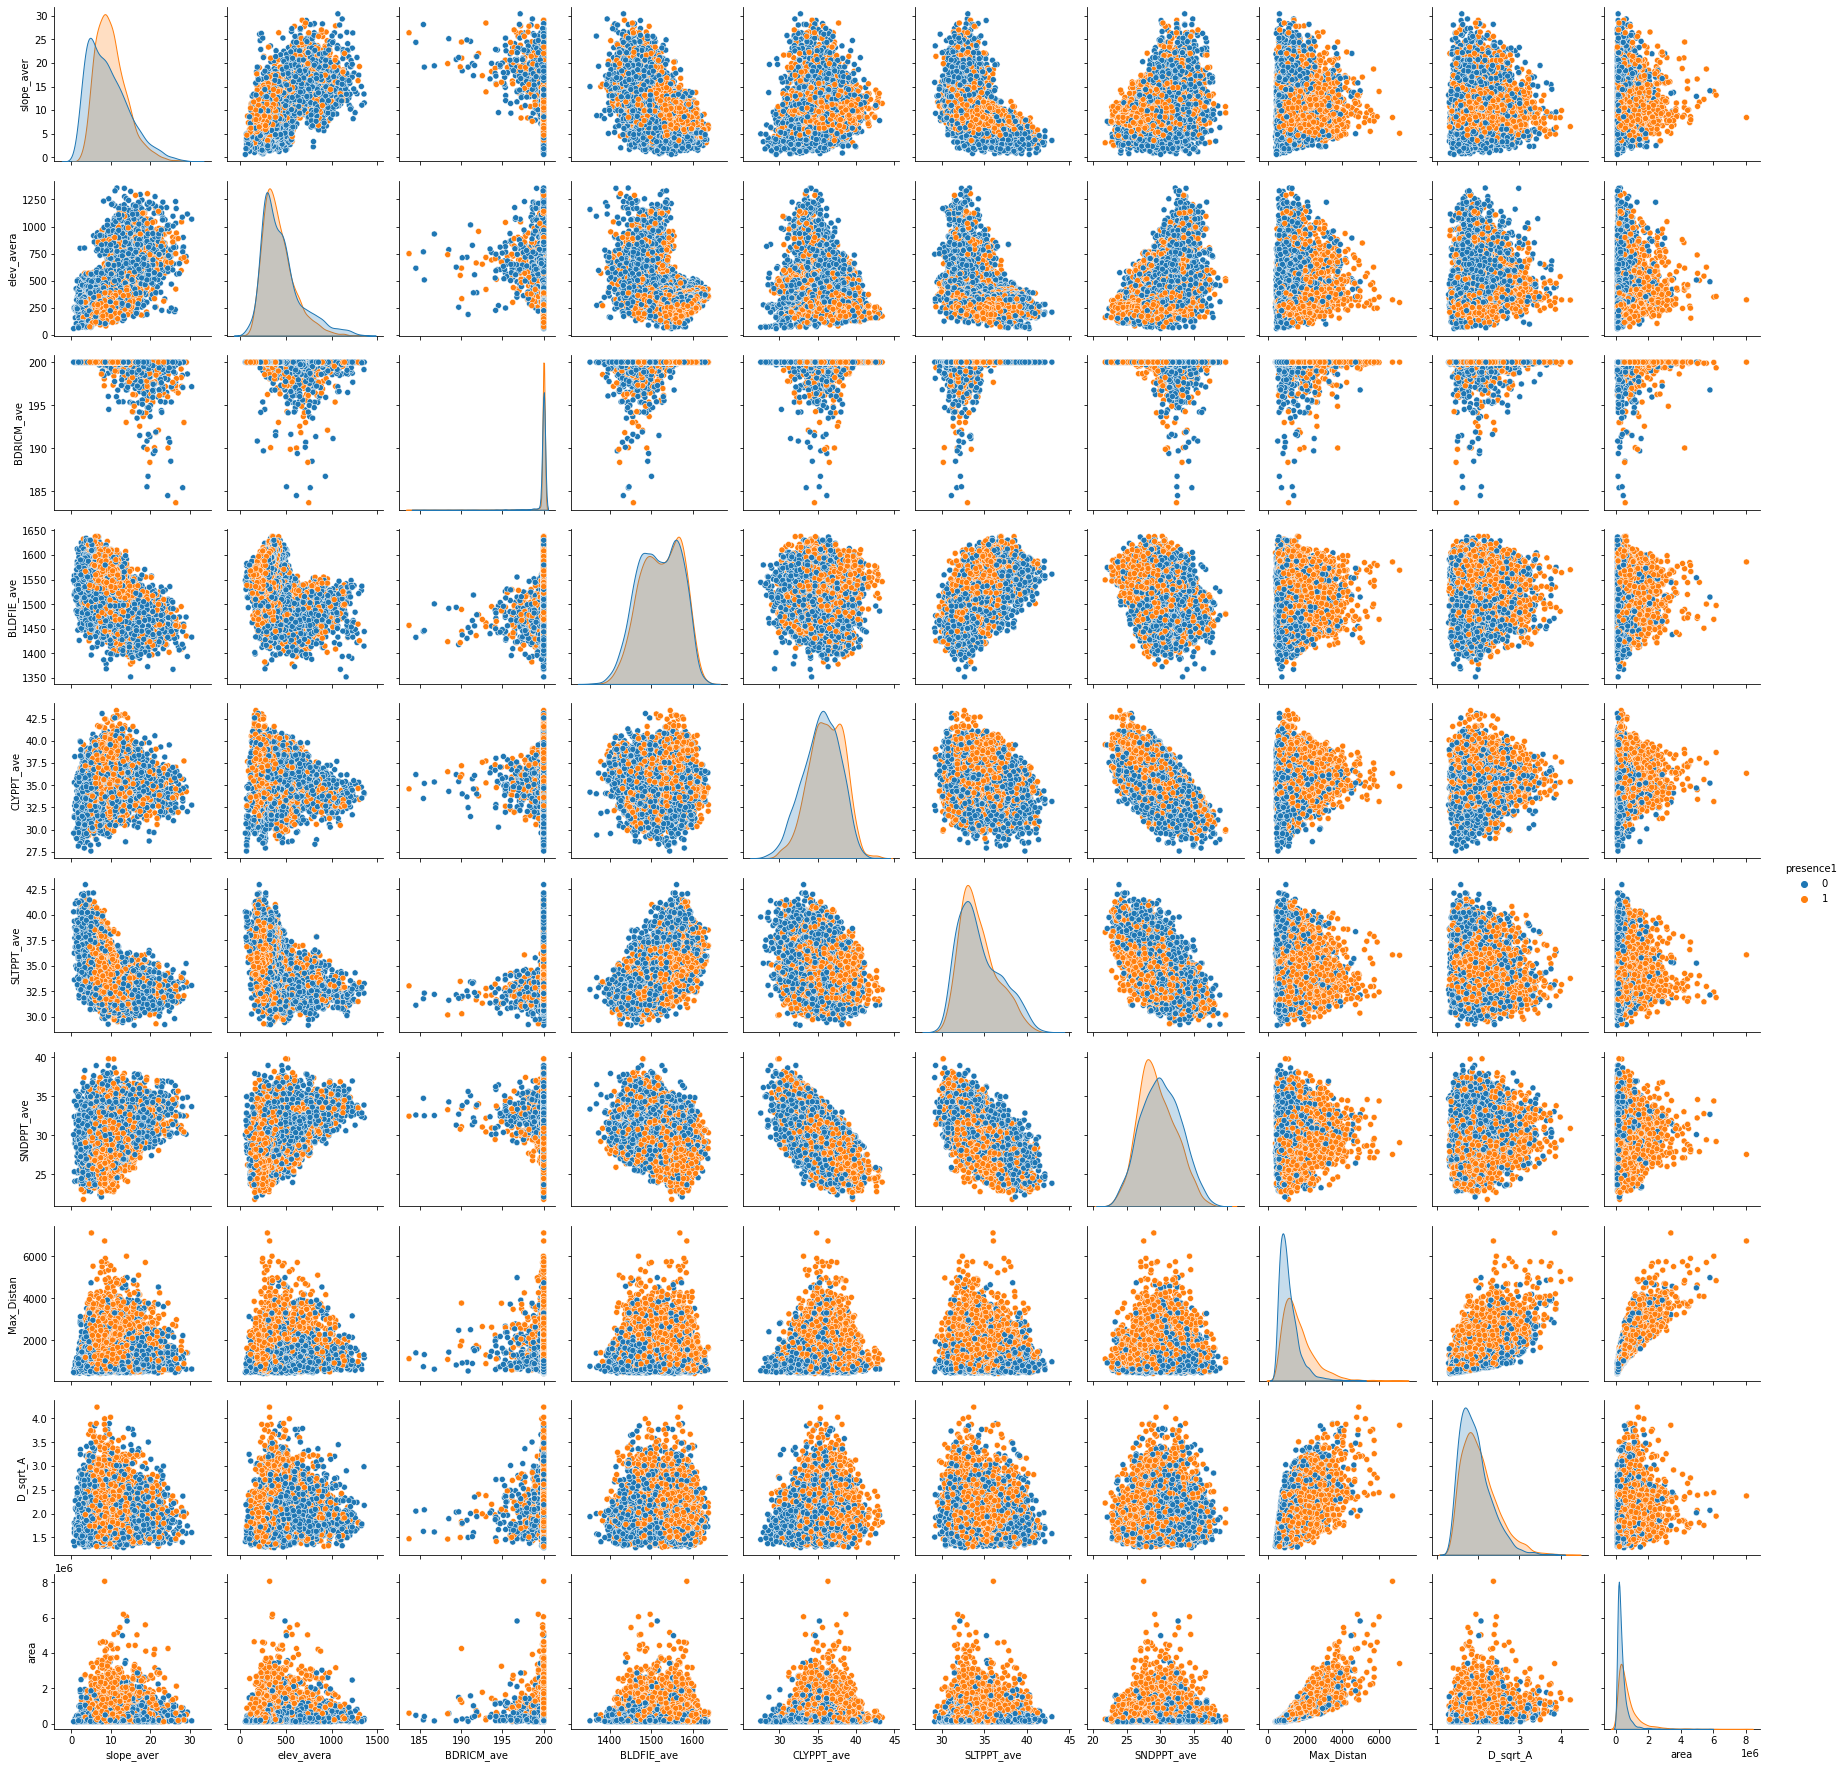

In [ ]:
sns.pairplot(selection_p1, hue='presence1', diag_kind='kde')

In [ ]:
selection_p2 = gdf[['presence2','slope_aver', 'elev_avera',
       'BDRICM_ave', 'BLDFIE_ave', 'CLYPPT_ave', 'SLTPPT_ave', 'SNDPPT_ave',
       'Max_Distan', 'D_sqrt_A', 'area']]

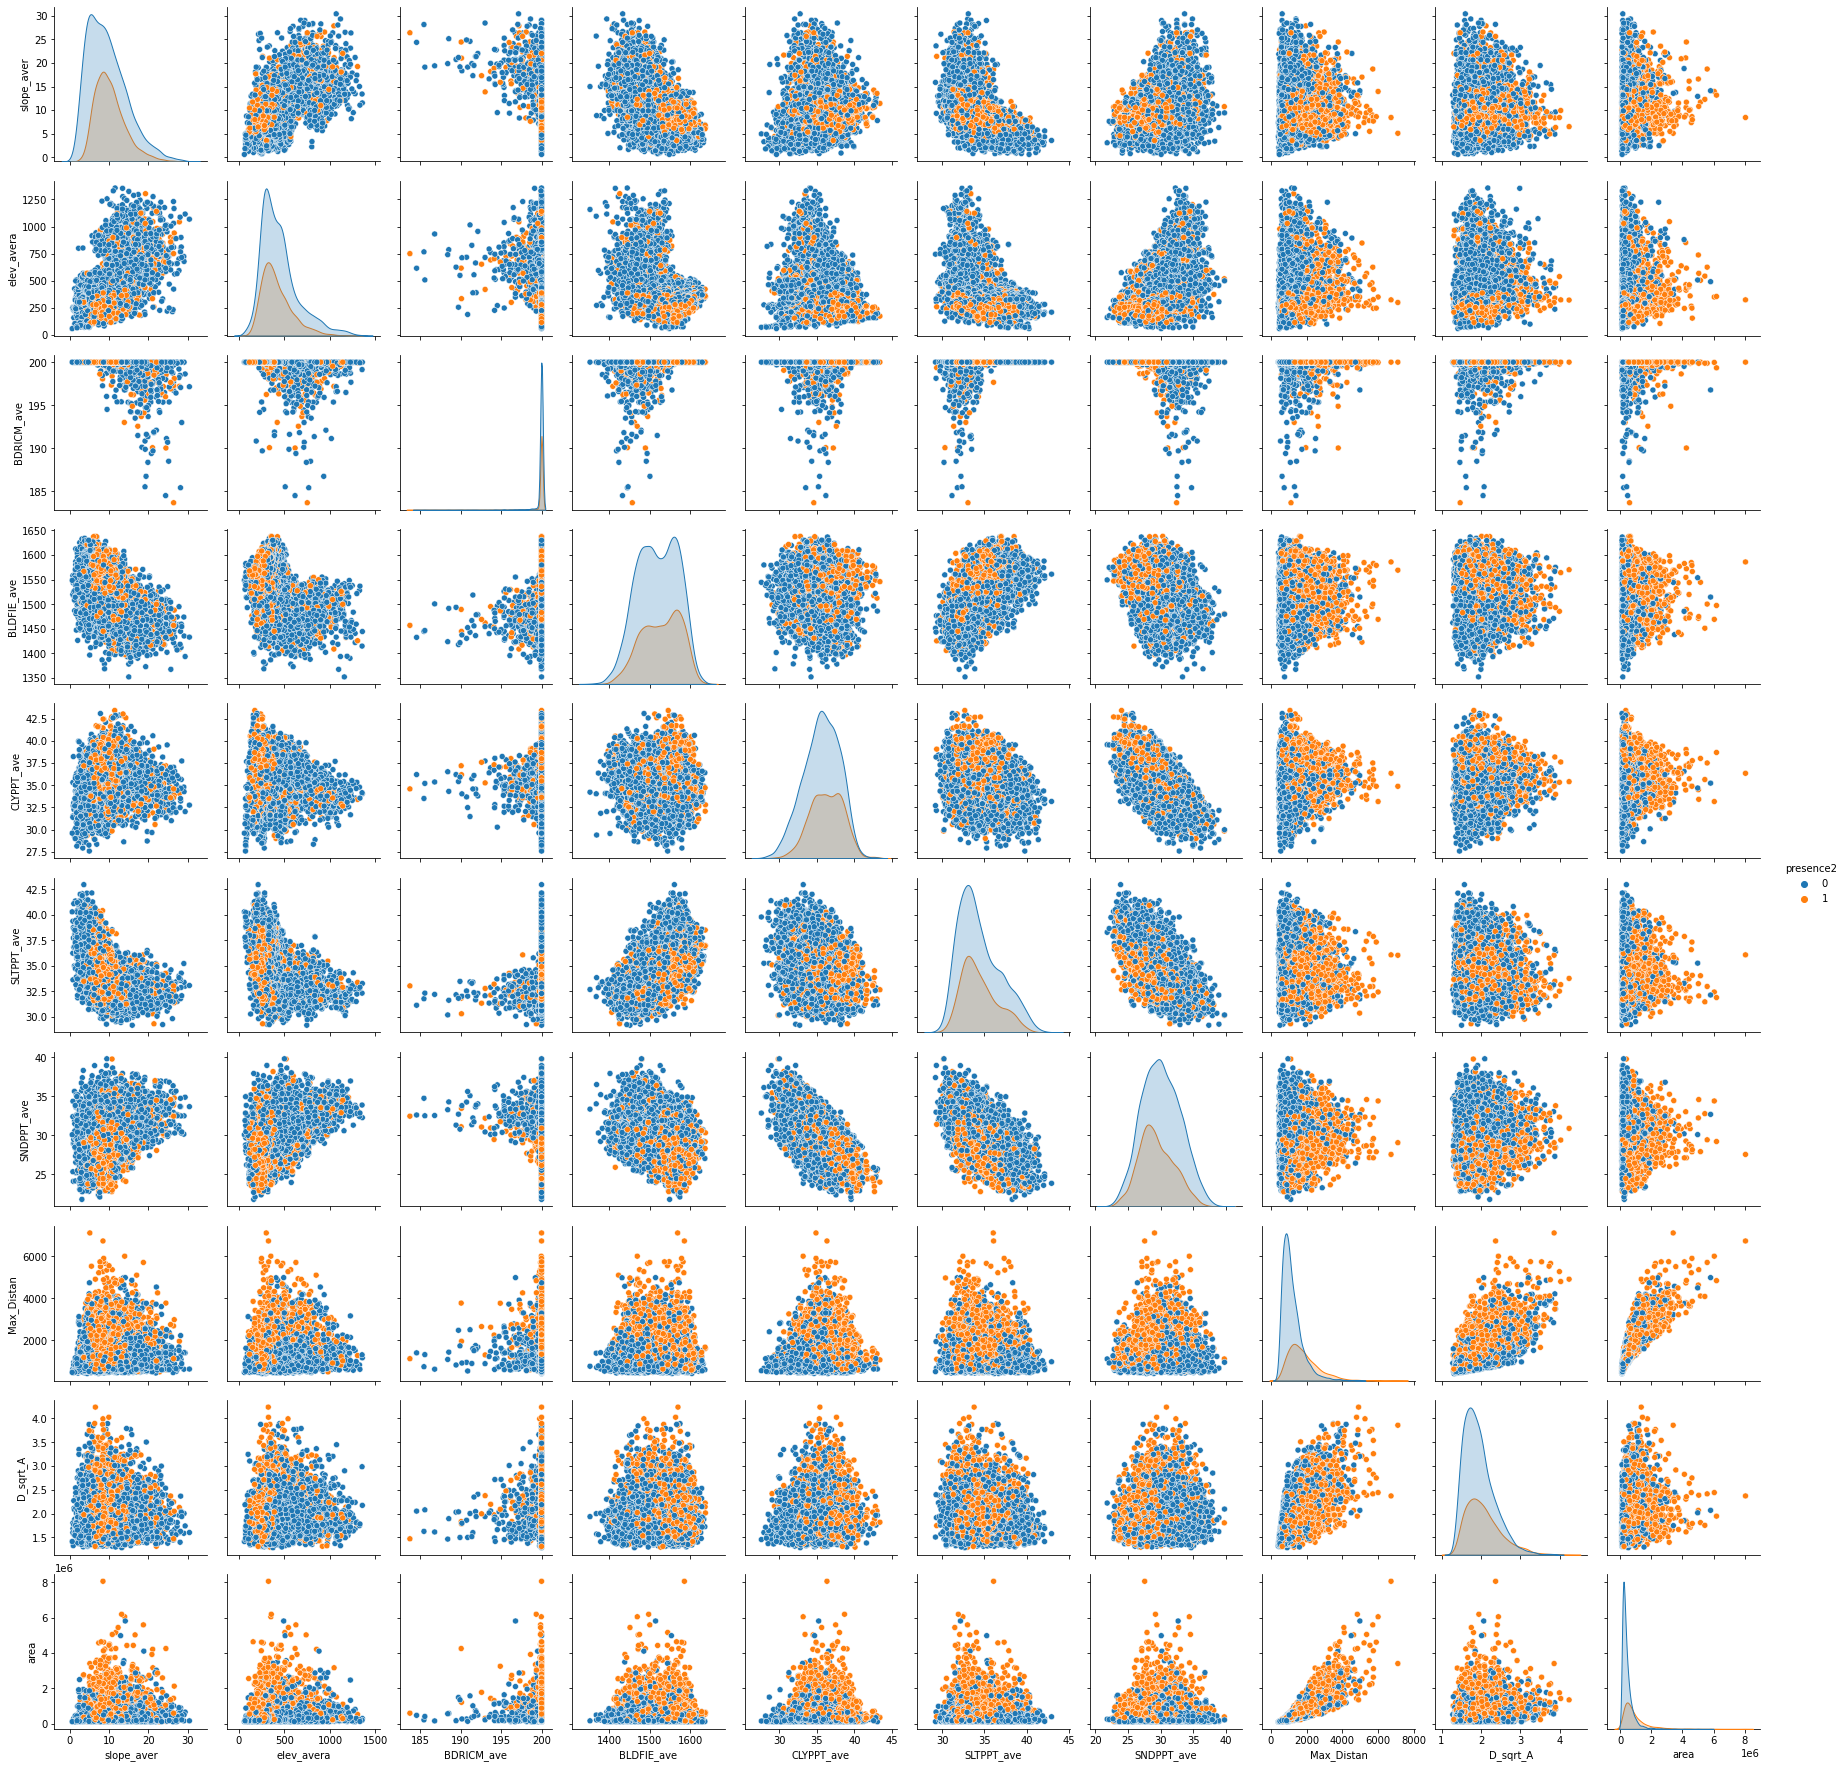

In [ ]:
sns.pairplot(selection_p2, hue='presence2', diag_kind='kde')

## Point-biserial correlation

### slope_aver

Point-biserial correlation of presence1 and slope_aver = 0.08490276488808005


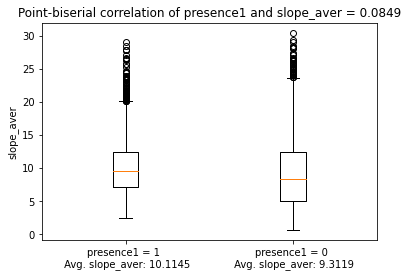

In [ ]:
get_point_biserial_correlation(gdf, "slope_aver", "presence1")

### twi_averag

Point-biserial correlation of presence1 and twi_averag = -0.12915420438955824


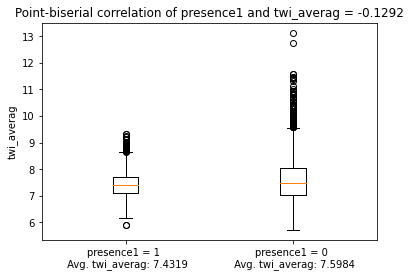

In [ ]:
get_point_biserial_correlation(gdf, "twi_averag", "presence1")

### pcurv_aver

Point-biserial correlation of presence1 and pcurv_aver = 0.08373289107275149


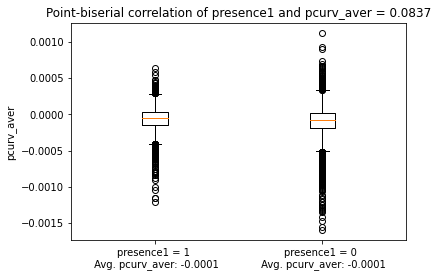

In [ ]:
get_point_biserial_correlation(gdf, "pcurv_aver", "presence1")

### Max_Distan


Point-biserial correlation of presence1 and Max_Distan = 0.3383099263795282


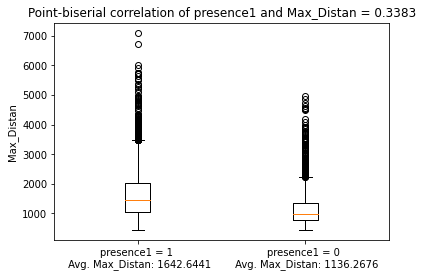

In [ ]:
get_point_biserial_correlation(gdf, "Max_Distan", "presence1")

### area

Point-biserial correlation of presence1 and area = 0.3135630642248536


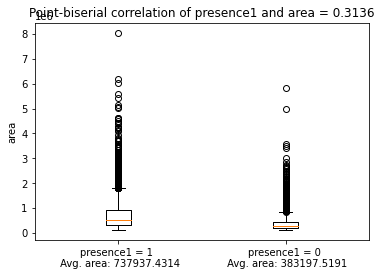

In [ ]:
get_point_biserial_correlation(gdf, "area", "presence1")

### elev_avera

Point-biserial correlation of presence1 and elev_avera = -0.06624892565524111


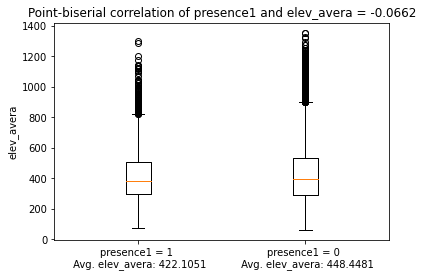

In [ ]:
get_point_biserial_correlation(gdf, "elev_avera", "presence1")

### elev_stdde

Point-biserial correlation of presence1 and elev_stdde = 0.18099615358120313


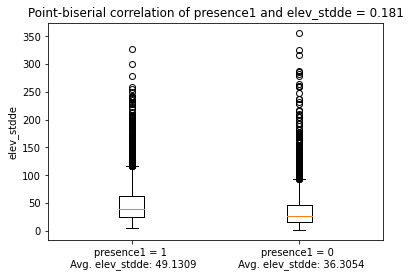

In [ ]:
get_point_biserial_correlation(gdf, "elev_stdde", "presence1")

## Prep Data for Calculations

Normalize inputs and set target values

In [ ]:
slope = minmax_scale(gdf[["slope_aver"]].values)
twi = minmax_scale(gdf[["twi_averag"]].values)
area = minmax_scale(gdf[["area"]].values)
y = gdf["presence1"].values

## ANN with Slope Units

In [ ]:
for col in gdf.columns:
  if col == "geometry": continue # invalid type
  X_tmp = minmax_scale(gdf[[col]].values)
  X_train, X_val, y_train, y_val = train_test_split(X_tmp, y, test_size=0.2, random_state=42)
  ann_tmp = MLPClassifier(random_state=42, max_iter=600).fit(X_train, y_train)
  auc = roc_auc_score(y_val, ann_tmp.predict_proba(X_val)[:, 1])
  print(f"X: {col} -> {auc = }")
  # Baseline infos

X: id -> auc = 1.0
X: slope_aver -> auc = 0.6389684654982296
X: slope_stdd -> auc = 0.6331835384470463
X: pcurv_aver -> auc = 0.5289495702863096
X: pcurv_stdd -> auc = 0.6224670164959079
X: tcurv_aver -> auc = 0.5506596700818424
X: tcurv_stdd -> auc = 0.6282186968399005
X: nthns_aver -> auc = 0.5412822516147742
X: nthns_stdd -> auc = 0.5183143180638595
X: easns_aver -> auc = 0.504524322736869
X: easns_stdd -> auc = 0.5313045453789849
X: elev_avera -> auc = 0.5760823188470042
X: elev_stdde -> auc = 0.6253317744321739
X: twi_averag -> auc = 0.6311074662869154
X: twi_stddev -> auc = 0.5600407826274872
X: BDRICM_ave -> auc = 0.5199360185590508
X: BDRICM_std -> auc = 0.519500117286995
X: BLDFIE_ave -> auc = 0.5429335047385793
X: BLDFIE_std -> auc = 0.597653890695909
X: CLYPPT_ave -> auc = 0.5779478285282607
X: CLYPPT_std -> auc = 0.5857183228144446
X: SLTPPT_ave -> auc = 0.5806297295749778
X: SLTPPT_std -> auc = 0.6168335466663711
X: SNDPPT_ave -> auc = 0.5750073419811712
X: SNDPPT_std -> a

### Slope and TWI

In [ ]:
slope_train, slope_val, twi_train, twi_val, y_train, y_val = train_test_split(
  slope, twi, y, test_size=0.2, random_state=42)
X_train = np.concatenate((slope_train, twi_train), axis=1)
X_val = np.concatenate((slope_val, twi_val), axis=1)
ann_slope_twi = MLPClassifier(random_state=42, max_iter=600).fit(X_train, y_train)
auc_train = roc_auc_score(y_train, ann_slope_twi.predict_proba(X_train)[:, 1])
auc_val = roc_auc_score(y_val, ann_slope_twi.predict_proba(X_val)[:, 1])
print(f"{auc_train = }")
print(f"{auc_val = }")

auc_train = 0.6756930980245026
auc_val = 0.6553258454360582


### All possible inputs

In [ ]:
min_max_scaler = MinMaxScaler()
gdf_normalized = gdf.copy(deep=True)
gdf_normalized[['slope_aver', 'slope_stdd', 'pcurv_aver', 'pcurv_stdd',
  'tcurv_aver', 'tcurv_stdd', 'nthns_aver', 'nthns_stdd', 'easns_aver',
  'easns_stdd', 'elev_avera', 'elev_stdde', 'twi_averag', 'twi_stddev',
  'BDRICM_ave', 'BDRICM_std', 'BLDFIE_ave', 'BLDFIE_std', 'CLYPPT_ave',
  'CLYPPT_std', 'SLTPPT_ave', 'SLTPPT_std', 'SNDPPT_ave', 'SNDPPT_std',
  'Max_Distan', 'D_sqrt_A', 'area']] = min_max_scaler.fit_transform(gdf_normalized[
  ['slope_aver', 'slope_stdd', 'pcurv_aver', 'pcurv_stdd',
  'tcurv_aver', 'tcurv_stdd', 'nthns_aver', 'nthns_stdd', 'easns_aver',
  'easns_stdd', 'elev_avera', 'elev_stdde', 'twi_averag', 'twi_stddev',
  'BDRICM_ave', 'BDRICM_std', 'BLDFIE_ave', 'BLDFIE_std', 'CLYPPT_ave',
  'CLYPPT_std', 'SLTPPT_ave', 'SLTPPT_std', 'SNDPPT_ave', 'SNDPPT_std',
  'Max_Distan', 'D_sqrt_A', 'area']])

train, test = train_test_split(gdf_normalized, test_size=0.3, random_state=42)
X_train = train[['slope_aver', 'slope_stdd', 'pcurv_aver', 'pcurv_stdd',
  'tcurv_aver', 'tcurv_stdd', 'nthns_aver', 'nthns_stdd', 'easns_aver',
  'easns_stdd', 'elev_avera', 'elev_stdde', 'twi_averag', 'twi_stddev',
  'BDRICM_ave', 'BDRICM_std', 'BLDFIE_ave', 'BLDFIE_std', 'CLYPPT_ave',
  'CLYPPT_std', 'SLTPPT_ave', 'SLTPPT_std', 'SNDPPT_ave', 'SNDPPT_std',
  'Max_Distan', 'D_sqrt_A', 'area']]
y_train = train["presence1"]
X_test = test[['slope_aver', 'slope_stdd', 'pcurv_aver', 'pcurv_stdd',
  'tcurv_aver', 'tcurv_stdd', 'nthns_aver', 'nthns_stdd', 'easns_aver',
  'easns_stdd', 'elev_avera', 'elev_stdde', 'twi_averag', 'twi_stddev',
  'BDRICM_ave', 'BDRICM_std', 'BLDFIE_ave', 'BLDFIE_std', 'CLYPPT_ave',
  'CLYPPT_std', 'SLTPPT_ave', 'SLTPPT_std', 'SNDPPT_ave', 'SNDPPT_std',
  'Max_Distan', 'D_sqrt_A', 'area']]
y_test = test["presence1"]
ann_all = MLPClassifier(random_state=42).fit(X_train, y_train)
auc_train = roc_auc_score(y_train, ann_all.predict_proba(X_train)[:, 1])
auc_test = roc_auc_score(y_test, ann_all.predict_proba(X_test)[:, 1])
print(f"{auc_train = }")
print(f"{auc_test = }")
ann_all.score(X_test, y_test)

auc_train = 0.8283987669426647
auc_test = 0.8082468657821649


/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0.7332427536231884

### All possible without information about the slope area and derived information

In [ ]:
train, test = train_test_split(gdf_normalized, test_size=0.2, random_state=42)
X_train = train[['slope_aver', 'slope_stdd', 'pcurv_aver', 'pcurv_stdd',
  'tcurv_aver', 'tcurv_stdd', 'nthns_aver', 'nthns_stdd', 'easns_aver',
  'easns_stdd', 'elev_avera', 'elev_stdde', 'twi_averag', 'twi_stddev',
  'BDRICM_ave', 'BDRICM_std', 'BLDFIE_ave', 'BLDFIE_std', 'CLYPPT_ave',
  'CLYPPT_std', 'SLTPPT_ave', 'SLTPPT_std', 'SNDPPT_ave', 'SNDPPT_std']]
y_train = train["presence1"]
X_test = test[['slope_aver', 'slope_stdd', 'pcurv_aver', 'pcurv_stdd',
  'tcurv_aver', 'tcurv_stdd', 'nthns_aver', 'nthns_stdd', 'easns_aver',
  'easns_stdd', 'elev_avera', 'elev_stdde', 'twi_averag', 'twi_stddev',
  'BDRICM_ave', 'BDRICM_std', 'BLDFIE_ave', 'BLDFIE_std', 'CLYPPT_ave',
  'CLYPPT_std', 'SLTPPT_ave', 'SLTPPT_std', 'SNDPPT_ave', 'SNDPPT_std']]
y_test = test["presence1"]
ann_no_area = MLPClassifier(random_state=42, max_iter=600).fit(X_train, y_train)
auc_train = roc_auc_score(y_train, ann_no_area.predict_proba(X_train)[:, 1])
auc_test = roc_auc_score(y_test, ann_no_area.predict_proba(X_test)[:, 1])
print(f"{auc_train = }")
print(f"{auc_test = }")

auc_train = 0.8234492272615767
auc_test = 0.7889369734783629


### Area

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(area, y, test_size=0.2, random_state=42)
ann_area = MLPClassifier(random_state=42, max_iter=600).fit(X_train, y_train)
auc_train = roc_auc_score(y_train, ann_area.predict_proba(X_train)[:, 1])
auc_val = roc_auc_score(y_val, ann_area.predict_proba(X_val)[:, 1])
print(f"{auc_train = }")
print(f"{auc_val = }")

auc_train = 0.7232990952250394
auc_val = 0.7156483015550223


## LR with Slope Units

In [ ]:
for col in gdf.columns:
  if col == "geometry":continue # invalid type
  X_tmp = minmax_scale(gdf[[col]].values)
  X_train, X_val, y_train, y_val = train_test_split(X_tmp, y, test_size=0.2, random_state=42)
  lr_tmp = LogisticRegression(random_state=42).fit(X_train, y_train)
  auc = roc_auc_score(y_val, lr_tmp.predict_proba(X_val)[:, 1])
  print(f"X: {col} -> {auc = }")

X: id -> auc = 1.0
X: slope_aver -> auc = 0.5616569420048134
X: slope_stdd -> auc = 0.5430498682137468
X: pcurv_aver -> auc = 0.5209906779927116
X: pcurv_stdd -> auc = 0.5579388519173192
X: tcurv_aver -> auc = 0.5312528282789103
X: tcurv_stdd -> auc = 0.5539677174473178
X: nthns_aver -> auc = 0.5412822516147742
X: nthns_stdd -> auc = 0.5335874859394134
X: easns_aver -> auc = 0.5008948905352166
X: easns_stdd -> auc = 0.485117480933937
X: elev_avera -> auc = 0.5232717715138518
X: elev_stdde -> auc = 0.6259394503580485
X: twi_averag -> auc = 0.5503881553064515
X: twi_stddev -> auc = 0.4959577545173963
X: BDRICM_ave -> auc = 0.5199360185590508
X: BDRICM_std -> auc = 0.519500117286995
X: BLDFIE_ave -> auc = 0.5429335047385793
X: BLDFIE_std -> auc = 0.597653890695909
X: CLYPPT_ave -> auc = 0.5779478285282607
X: CLYPPT_std -> auc = 0.5857183228144446
X: SLTPPT_ave -> auc = 0.47555720557731984
X: SLTPPT_std -> auc = 0.6168335466663711
X: SNDPPT_ave -> auc = 0.5726412846527659
X: SNDPPT_std -> 

### Slope and TWI

In [ ]:
slope_train, slope_val, twi_train, twi_val, y_train, y_val = train_test_split(
  slope, twi, y, test_size=0.2, random_state=42)
X_train = np.concatenate((slope_train, twi_train), axis=1)
X_val = np.concatenate((slope_val, twi_val), axis=1)
lr_slope_twi = LogisticRegression(random_state=42).fit(X_train, y_train)
auc_train = roc_auc_score(y_train, lr_slope_twi.predict_proba(X_train)[:, 1])
auc_val = roc_auc_score(y_val, lr_slope_twi.predict_proba(X_val)[:, 1])
print(f"{auc_train = }")
print(f"{auc_val = }")

auc_train = 0.5495234274664859
auc_val = 0.5513652390900007


## Area

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(area, y, test_size=0.2, random_state=42)
lr_area = LogisticRegression(random_state=42).fit(X_train, y_train)
auc_train = roc_auc_score(y_train, lr_area.predict_proba(X_train)[:, 1])
auc_val = roc_auc_score(y_val, lr_area.predict_proba(X_val)[:, 1])
print(f"{auc_train = }")
print(f"{auc_val = }")

auc_train = 0.7232990952250394
auc_val = 0.7156483015550223


# Random Inventory

We examine a landslide distribution with the same probability as presence1

In [ ]:
su_with_presence1_count = len(gdf.loc[gdf["presence1"] == 1])
random_gdf = gdf.copy(deep=True)
np.random.seed(42)
prob_p1 = random_gdf["presence1"].value_counts()[1] / random_gdf.shape[0]
random_gdf["presenceProbLikeP1"] = np.random.choice(2, random_gdf.shape[0], p=[1-prob_p1, prob_p1])
# generate a binary column with the same probabilities as presence1

In [ ]:
random_gdf["presenceProbLikeP1"].value_counts()[1] # SU with LS

3556

## slope_aver

Point-biserial correlation of presenceProbLikeP1 and slope_aver = 0.014689697403756885


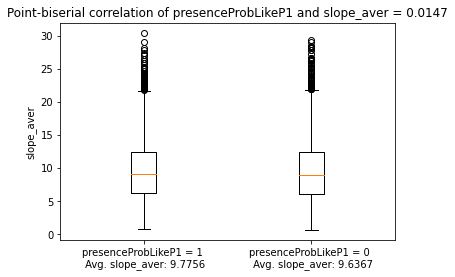

In [ ]:
get_point_biserial_correlation(random_gdf, "slope_aver", "presenceProbLikeP1")

## twi_averag

Point-biserial correlation of presenceProbLikeP1 and twi_averag = -0.011069936420188348


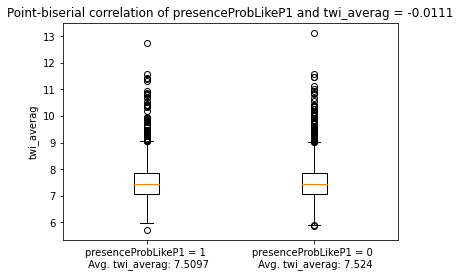

In [ ]:
get_point_biserial_correlation(random_gdf, "twi_averag", "presenceProbLikeP1")

## pcurv_aver

Point-biserial correlation of presenceProbLikeP1 and pcurv_aver = -0.011360750415214093


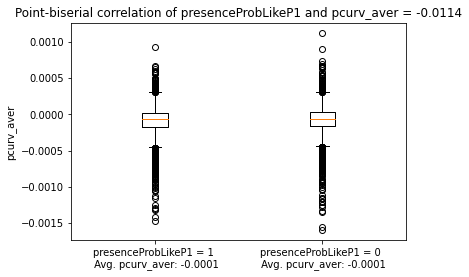

In [ ]:
get_point_biserial_correlation(random_gdf, "pcurv_aver", "presenceProbLikeP1")

## Max_Distan

Point-biserial correlation of presenceProbLikeP1 and Max_Distan = 0.021747094763670056


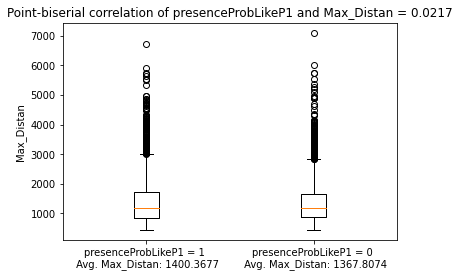

In [ ]:
get_point_biserial_correlation(random_gdf, "Max_Distan", "presenceProbLikeP1")

## area

Point-biserial correlation of presenceProbLikeP1 and area = 0.02295438297766464


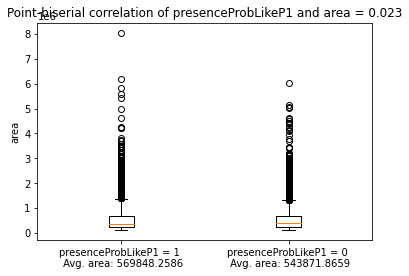

In [ ]:
get_point_biserial_correlation(random_gdf, "area", "presenceProbLikeP1")

# Cell Grids

See LSAT Calculations.
* Inventory: https://idrogeo.isprambiente.it/opendata/frane/frane_piff_umbria_opendata.zip (2022-12-13)
* 80/20 Inventory split (seed: 42)
* Base information: EU DEM (25mx25m)
* Derived information: Slope, Height

The dataset contains 6552448 cells.
Prior Logit = -6,556697817 (Training data)

### WoE

As part of the approach we applied Weights of Evidence to slope and height rasters with the point inventory from which the "presence" information was derived for the SU.
Slope and Height were reclassified (Slope to 5° and height to 10 quantils classes).

#### Back to SU

We calculated the posterior probability for each cell in the resulting validation and test raster.
$$p_{post} = \frac{1}{1+e^{-z}}$$

With:
* $e$ = Euler's Number (2.718281828)
* $z$ = Weight of the cell + prior logit (-6,556697817 (Training data))

We calculated the mean and median of the posterior probability for each SU.


# Best possible AUC value based on point frequency and SU area

## Basic Idea
The validation with Receiver Operating Characteristics (ROC) Curve or related success rate on discrete spatial datasets is strongly governed by the size of unique conditions enabled by the model. This allows us to estimate the best possible model outcome given by the restricted geometry constellation of discrete units (in this case, Slope Units). Specifically, any applied model cannot change slope units in shape (no hyperplane can cross the boundaries of the slope units!). Therefore, they provide a hard spatial constraint on the model performance, preserving the basic geometry pattern. The latter makes the model depend only on ranking the slope units along the x-axis of ROC or success rate.
This enables us to investigate the best possible ranking of slope units to maximize the AUROC value in a simple descriptive way without considering the causal factors.



## Design 1
We use original point data to estimate the event frequency in slope units. We use the frequency ratio in the slope unit area (corresponding to a conditional probability) to rank the slope units. Based on the ranking, we compute the success rate proposed by *Chung and Fabbri (2003)*.

General comment: Applying slope units as fixed geometrical boundaries (unique classes) seems to stand entirely in contrast to the classical raster-based landslide susceptibility assessment. In the latter, the involvement of several parameters is aimed to increase the area's discrimination to smaller unique condition areas and narrow the landslide-prone areas. With slope units as fixed discrete units (classes), the only possibility to improve the model is to rearrange the slope unit's relative ranking.

In [ ]:
gdf_su = geopandas.read_file("dataset_benchmark/su_benchmark/su_benchmark.shp")

In [ ]:
gdf_points = geopandas.read_file("frane_piff_opendataPoint.shp")

First we perform spatial join using geopandas and create a pivot table:

In [ ]:
sjoin = geopandas.sjoin(gdf_su, gdf_points) #Spatial join Points to polygons
pivot = pd.pivot_table(sjoin,index='id',columns='nome_tipo',aggfunc={'nome_tipo':len})
pivot.columns = pivot.columns.droplevel()
pivot

nome_tipo  Aree con crolli/ribaltamenti diffusi  \
id                                                
8                                           2.0   
12                                          NaN   
13                                          NaN   
27                                          NaN   
32                                          NaN   
...                                         ...   
7727                                        NaN   
7728                                        NaN   
7729                                        NaN   
7730                                        NaN   
7732                                        1.0   

nome_tipo  Aree con frane superficiali diffuse  \
id                                               
8                                          NaN   
12                                         NaN   
13                                         NaN   
27                                         NaN   
32                                         NaN   
...                                        ...   
7727                                       NaN   
7728                                       2.0   
7729                                       NaN   
7730                                       NaN   
7732                                       NaN   

nome_tipo  Aree con sprofondamenti diffusi  Colamento lento  Colamento rapido  \
id                                                                              
8                                      NaN              NaN               NaN   
12                                     NaN              NaN               NaN   
13                                     NaN              NaN               NaN   
27                                     NaN              NaN               NaN   
32                                     NaN              1.0               NaN   
...                                    ...              ...               ...   
7727                                   NaN              5.0               NaN   
7728                                   NaN              1.0               NaN   
7729                                   NaN              2.0               NaN   
7730                                   NaN              3.0               NaN   
7732                                   NaN              4.0               NaN   

nome_tipo  Complesso  Crollo/Ribaltamento  \
id                                          
8                NaN                  NaN   
12               NaN                  NaN   
13               NaN                  NaN   
27               1.0                  NaN   
32               1.0                  NaN   
...              ...                  ...   
7727             6.0                  NaN   
7728             5.0                  NaN   
7729             8.0                  NaN   
7730             3.0                  NaN   
7732            11.0                  NaN   

nome_tipo  Scivolamento rotazionale/traslativo  Sprofondamento  n.d.  
id                                                                    
8                                          NaN             NaN   NaN  
12                                         NaN             NaN   1.0  
13                                         NaN             NaN   1.0  
27                                         NaN             NaN   2.0  
32                                         NaN             NaN   NaN  
...                                        ...             ...   ...  
7727                                      32.0             NaN   3.0  
7728                                      34.0             NaN  13.0  
7729                                      37.0             NaN   1.0  
7730                                      39.0             NaN   5.0  
7732                                      44.0             NaN   1.0  

[4146 rows x 10 columns]

In the next step we join the gedataframe (*gdf_su*) based on slope unit *id* with the generated pivot table and select only the columns *id*, *area* and a selected movement type (here: rotational/translational) exporting it to a new geodataframe *gdf_type*:

In [ ]:
gdf_su_new = gdf_su.merge(pivot, how='left', on='id')
gdf_type = gdf_su_new[["Scivolamento rotazionale/traslativo", "area", "id"]]
gdf_type

Scivolamento rotazionale/traslativo          area    id
0                                     6.0  1.214823e+06  7162
1                                     NaN  2.572250e+05  3364
2                                     NaN  2.797528e+05  3362
3                                     2.0  1.002032e+06  5551
4                                     1.0  5.726094e+05  5184
...                                   ...           ...   ...
7355                                  NaN  4.917642e+05  2817
7356                                  1.0  8.777787e+05  5096
7357                                 11.0  1.163213e+06  7572
7358                                  7.0  8.740519e+05  7323
7359                                  5.0  5.430775e+05  6972

[7360 rows x 3 columns]

To account for differly sized slope units we normalize the event count in the column "Scivolamento rotazionale/traslativo" with the slope unit area.

In [ ]:
FR = (gdf_type["Scivolamento rotazionale/traslativo"]/gdf_type.area)/(gdf_type["Scivolamento rotazionale/traslativo"].sum()/gdf_type.area.sum())

We add the computed frequency to the gdf_type as a new column:

In [ ]:
gdf_type["freq_ratio"] = FR
gdf_type

<ipython-input-43-b0d9a583f5a7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdf_type["freq_ratio"] = FR


Scivolamento rotazionale/traslativo          area    id  freq_ratio
0                                     6.0  1.214823e+06  7162    1.740064
1                                     NaN  2.572250e+05  3364         NaN
2                                     NaN  2.797528e+05  3362         NaN
3                                     2.0  1.002032e+06  5551    0.703194
4                                     1.0  5.726094e+05  5184    0.615274
...                                   ...           ...   ...         ...
7355                                  NaN  4.917642e+05  2817         NaN
7356                                  1.0  8.777787e+05  5096    0.401367
7357                                 11.0  1.163213e+06  7572    3.331658
7358                                  7.0  8.740519e+05  7323    2.821549
7359                                  5.0  5.430775e+05  6972    3.243658

[7360 rows x 4 columns]

We sort the obtained table by obtained freq_ratio descending (highest freq_ratios in the upper part).

In [ ]:
sorted_gdf_type = gdf_type.sort_values(by="freq_ratio", ascending=False)

We generate input for success rate normalizing the counts and area columns:

In [ ]:
count_norm = sorted_gdf_type["Scivolamento rotazionale/traslativo"]/sorted_gdf_type["Scivolamento rotazionale/traslativo"].sum()
area_norm = sorted_gdf_type.area/sorted_gdf_type.area.sum()

Now, we create x and y values for the success rate by calculating the cumulative sums for the normalized series starting with 0:

In [ ]:
x=[0]
for elem in area_norm.cumsum():
    x.append(elem)
y=[0]
for elem in count_norm.fillna(0).cumsum():
    y.append(elem)

Calculate AUC for the success rate curve and plot it:

In [ ]:
auc = calc_auc(x,y)
auc

0.8071063483122974

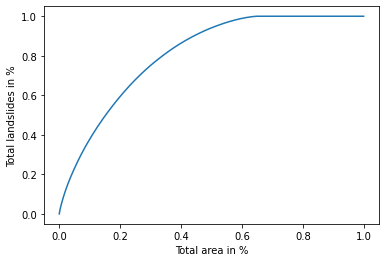

In [ ]:
plt.xlabel("Total area in %")
plt.ylabel("Total landslides in %")
plt.plot(x, y)

## Design 2
The benchmark dataset provides binary labels for slope units with columns presence1 and presence2. The simple binary labeling restricts us from applying any algorithm that could rank the slope units on the event frequencies. 
To maximize the AUROC, we need to bring small slope units to the left corner of the x-axis. Therefore, the relative ranking can be organized in the way that we sort all slope units in descending order for the presence of landslides and ascending order for the areas of the slope units. 
 

In [ ]:
sorted2 = gdf_su.sort_values(["presence2", "area"], ascending=[False, True])[["id", "area", "presence2"]]

In [ ]:
norm_area = sorted2.area/sorted2.area.sum()
norm_presence2 = sorted2.presence2/sorted2.presence2.sum()

In [ ]:
x=[0]
for elem in area_norm.cumsum():
    x.append(elem)
y=[0]
for elem in norm_presence2.cumsum():
    y.append(elem)

In [ ]:
auc = calc_auc(x,y)
auc

0.8498387469992227

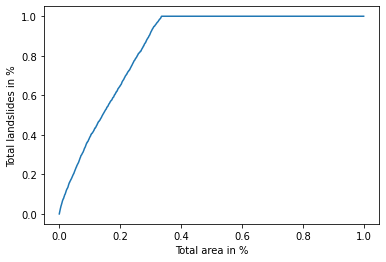

In [ ]:
plt.xlabel("Total area in %")
plt.ylabel("Total landslides in %")
plt.plot(x, y)

#Regression Analysis

## All possible inputs

In [ ]:
dataX = gdf_su_new.drop(["id", "Colamento rapido", "presence1", "presence2",
                         "Aree con crolli/ribaltamenti diffusi",
                         "Aree con frane superficiali diffuse",
                         "Aree con sprofondamenti diffusi", 
                         "Colamento lento",
                         "Colamento rapido", 
                         "Complesso", 
                         "Crollo/Ribaltamento",
                         "Scivolamento rotazionale/traslativo", 
                         "Sprofondamento", "geometry",
                         "n.d."], axis=1)
dataX.columns

Index(['slope_aver', 'slope_stdd', 'pcurv_aver', 'pcurv_stdd', 'tcurv_aver',
       'tcurv_stdd', 'nthns_aver', 'nthns_stdd', 'easns_aver', 'easns_stdd',
       'elev_avera', 'elev_stdde', 'twi_averag', 'twi_stddev', 'BDRICM_ave',
       'BDRICM_std', 'BLDFIE_ave', 'BLDFIE_std', 'CLYPPT_ave', 'CLYPPT_std',
       'SLTPPT_ave', 'SLTPPT_std', 'SNDPPT_ave', 'SNDPPT_std', 'Max_Distan',
       'D_sqrt_A', 'area'],
      dtype='object')

In [ ]:
dataY = gdf_su_new["Scivolamento rotazionale/traslativo"].fillna(0)

In [ ]:
column_transformer = make_column_transformer((StandardScaler(), ['slope_aver', 'slope_stdd', 'pcurv_aver', 'pcurv_stdd', 'tcurv_aver',
       'tcurv_stdd', 'nthns_aver', 'nthns_stdd', 'easns_aver', 'easns_stdd',
       'elev_avera', 'elev_stdde', 'twi_averag', 'twi_stddev', 'BDRICM_ave',
       'BDRICM_std', 'BLDFIE_ave', 'BLDFIE_std', 'CLYPPT_ave', 'CLYPPT_std',
       'SLTPPT_ave', 'SLTPPT_std', 'SNDPPT_ave', 'SNDPPT_std', 'Max_Distan',
       'D_sqrt_A', 'area']))


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(dataX, dataY, test_size = 0.3, random_state = 42, shuffle = True)
len(X_train), len(X_test)
X_train

slope_aver  slope_stdd  pcurv_aver  pcurv_stdd  tcurv_aver  tcurv_stdd  \
4951    3.532425    1.134937   -0.000028    0.000448    0.000033    0.000329   
2840    9.800628    6.100115    0.000018    0.001161    0.000006    0.001336   
4560    8.494932    3.722766   -0.000035    0.001673   -0.000166    0.001338   
2389    4.433271    1.503416    0.000012    0.000681   -0.000007    0.000592   
5507    7.420491    3.460850   -0.000107    0.001247    0.000123    0.001075   
...          ...         ...         ...         ...         ...         ...   
5191    2.454488    0.727024   -0.000003    0.000338    0.000020    0.000260   
5226    9.724233    3.258640    0.000030    0.001378    0.000026    0.001374   
5390   11.193326    4.558832    0.000205    0.001527   -0.000154    0.001385   
860    14.017114    3.168749   -0.000160    0.002755    0.000004    0.001197   
7270    8.445767    2.871142    0.000341    0.001076   -0.000329    0.001100   

      nthns_aver  nthns_stdd  easns_aver  easns_stdd  ...  BLDFIE_std  \
4951    0.266994    0.241690   -0.929732    0.076796  ...   15.599096   
2840    0.423837    0.386719    0.739381    0.352316  ...   39.021936   
4560    0.279870    0.361221   -0.863091    0.215098  ...   14.682724   
2389   -0.887083    0.127138   -0.170773    0.409581  ...   17.965969   
5507    0.544721    0.499918    0.152841    0.655745  ...   11.787470   
...          ...         ...         ...         ...  ...         ...   
5191   -0.403475    0.269684   -0.862460    0.143669  ...   17.784506   
5226   -0.314947    0.376050    0.827890    0.272016  ...   22.668174   
5390    0.099588    0.573103   -0.776479    0.242312  ...   15.730938   
860    -0.137139    0.213427   -0.966262    0.044493  ...   11.926906   
7270    0.502601    0.371841    0.720402    0.300246  ...   14.585527   

      CLYPPT_ave  CLYPPT_std  SLTPPT_ave  SLTPPT_std  SNDPPT_ave  SNDPPT_std  \
4951   29.810845    1.650120   39.127421    2.523881   31.243574    1.247649   
2840   38.215733    1.753603   33.756356    2.168954   28.069550    1.282283   
4560   37.392464    3.040462   35.739855    1.265863   26.972108    2.316080   
2389   37.783352    0.615877   39.281079    0.719881   23.259849    0.897833   
5507   35.342760    1.166391   38.070186    0.552352   26.514845    0.896485   
...          ...         ...         ...         ...         ...         ...   
5191   31.683913    2.237840   39.120736    1.397706   29.195841    1.549560   
5226   37.515544    1.330608   32.439660    0.648564   30.089413    1.872990   
5390   33.465584    2.937999   31.720225    0.699933   35.041623    2.856030   
860    38.305000    0.746864   32.947993    0.471019   28.694302    0.784862   
7270   40.471061    0.330234   31.599535    0.690320   28.201967    0.569002   

       Max_Distan  D_sqrt_A          area  
4951  1612.451550  1.715228  8.851108e+05  
2840  3145.035771  2.786657  1.274810e+06  
4560  1346.291202  2.209560  3.715022e+05  
2389  1280.624847  2.168527  3.491032e+05  
5507  1410.895106  2.125495  4.412558e+05  
...           ...       ...           ...  
5191  2747.385120  1.742178  2.490700e+06  
5226  2782.984010  3.144815  7.838387e+05  
5390  1500.000000  2.220700  4.566521e+05  
860    561.805126  1.380457  1.658408e+05  
7270   592.663480  1.543164  1.476650e+05  

[5152 rows x 27 columns]

In [ ]:
column_transformer.fit(X_train)
X_train_normal = column_transformer.transform(X_train)

id seems to based on the amount of landslides inside the SU

Text(0, 0.5, 'count translational/rotational landslides')

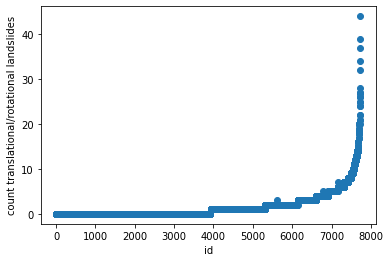

In [ ]:
plt.scatter(gdf_su_new.id, dataY)
plt.xlabel("id")
plt.ylabel("count translational/rotational landslides")

In [ ]:
N, D = X_train.shape
model = tf.keras.models.Sequential([tf.keras.layers.Input(shape=(D,)),
                             tf.keras.layers.Dense(300, activation="relu"),
                             tf.keras.layers.Dense(1)])
model.compile(loss = tf.keras.losses.mae,
             optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
             metrics=["mae"])

model.fit(X_train_normal, y_train, epochs = 300, verbose=0)

In [ ]:
X_test_norm = column_transformer.transform(X_test)

In [ ]:
y_pred = model.predict(X_test_norm)

69/69 [==============================] - 0s 1ms/step


In [ ]:
y_fit = model.predict(X_train_normal)

161/161 [==============================] - 0s 1ms/step


Text(0.5, 0, 'y_fit')

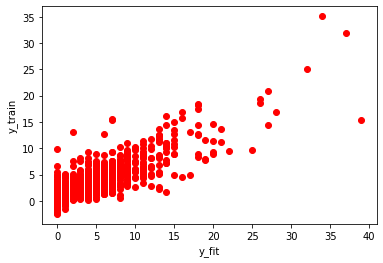

In [ ]:
plt.scatter(y_train, y_fit, c="r", label = "prediction")
plt.ylabel("y_train")
plt.xlabel("y_fit")

Text(0.5, 0, 'y_pred')

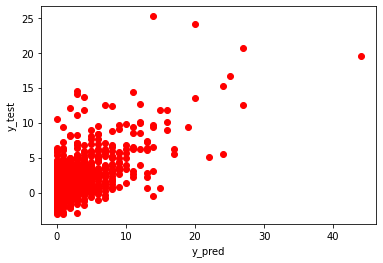

In [ ]:
plt.scatter(y_test, y_pred, c="r", label = "prediction")
plt.ylabel("y_test")
plt.xlabel("y_pred")

In [ ]:
model.evaluate(X_test_norm, y_test)

69/69 [==============================] - 0s 1ms/step - loss: 1.4724 - mae: 1.4724


[1.4724217653274536, 1.4724217653274536]

## All possible without information about the slope area and derived information

In [ ]:
dataX = gdf_su_new.drop(["id", "Colamento rapido", "presence1", "presence2",
  "Aree con crolli/ribaltamenti diffusi",
  "Aree con frane superficiali diffuse",
  "Aree con sprofondamenti diffusi", 
  "Colamento lento",
  "Colamento rapido", 
  "Complesso", 
  "Crollo/Ribaltamento",
  "Scivolamento rotazionale/traslativo", 
  "Sprofondamento", "geometry",
  "n.d.", "Max_Distan",
  "D_sqrt_A", "area"], axis=1)
dataY = gdf_su_new["Scivolamento rotazionale/traslativo"].fillna(0)
dataX.columns

Index(['slope_aver', 'slope_stdd', 'pcurv_aver', 'pcurv_stdd', 'tcurv_aver',
       'tcurv_stdd', 'nthns_aver', 'nthns_stdd', 'easns_aver', 'easns_stdd',
       'elev_avera', 'elev_stdde', 'twi_averag', 'twi_stddev', 'BDRICM_ave',
       'BDRICM_std', 'BLDFIE_ave', 'BLDFIE_std', 'CLYPPT_ave', 'CLYPPT_std',
       'SLTPPT_ave', 'SLTPPT_std', 'SNDPPT_ave', 'SNDPPT_std'],
      dtype='object')

In [ ]:
column_transformer = make_column_transformer((StandardScaler(), ['slope_aver', 'slope_stdd', 'pcurv_aver', 'pcurv_stdd', 'tcurv_aver',
       'tcurv_stdd', 'nthns_aver', 'nthns_stdd', 'easns_aver', 'easns_stdd',
       'elev_avera', 'elev_stdde', 'twi_averag', 'twi_stddev', 'BDRICM_ave',
       'BDRICM_std', 'BLDFIE_ave', 'BLDFIE_std', 'CLYPPT_ave', 'CLYPPT_std',
       'SLTPPT_ave', 'SLTPPT_std', 'SNDPPT_ave', 'SNDPPT_std']))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(dataX, dataY, test_size = 0.3, random_state = 42, shuffle = True)
X_train.head()

slope_aver  slope_stdd  pcurv_aver  pcurv_stdd  tcurv_aver  tcurv_stdd  \
4951    3.532425    1.134937   -0.000028    0.000448    0.000033    0.000329   
2840    9.800628    6.100115    0.000018    0.001161    0.000006    0.001336   
4560    8.494932    3.722766   -0.000035    0.001673   -0.000166    0.001338   
2389    4.433271    1.503416    0.000012    0.000681   -0.000007    0.000592   
5507    7.420491    3.460850   -0.000107    0.001247    0.000123    0.001075   

      nthns_aver  nthns_stdd  easns_aver  easns_stdd  ...  BDRICM_ave  \
4951    0.266994    0.241690   -0.929732    0.076796  ...  200.000000   
2840    0.423837    0.386719    0.739381    0.352316  ...  199.507863   
4560    0.279870    0.361221   -0.863091    0.215098  ...  200.000000   
2389   -0.887083    0.127138   -0.170773    0.409581  ...  200.000000   
5507    0.544721    0.499918    0.152841    0.655745  ...  200.000000   

      BDRICM_std   BLDFIE_ave  BLDFIE_std  CLYPPT_ave  CLYPPT_std  SLTPPT_ave  \
4951    0.000000  1546.616455   15.599096   29.810845    1.650120   39.127421   
2840    1.570049  1487.889076   39.021936   38.215733    1.753603   33.756356   
4560    0.000000  1568.789068   14.682724   37.392464    3.040462   35.739855   
2389    0.000000  1563.718755   17.965969   37.783352    0.615877   39.281079   
5507    0.000000  1592.753129   11.787470   35.342760    1.166391   38.070186   

      SLTPPT_std  SNDPPT_ave  SNDPPT_std  
4951    2.523881   31.243574    1.247649  
2840    2.168954   28.069550    1.282283  
4560    1.265863   26.972108    2.316080  
2389    0.719881   23.259849    0.897833  
5507    0.552352   26.514845    0.896485  

[5 rows x 24 columns]

In [ ]:
column_transformer.fit(X_train)
X_train_normal = column_transformer.transform(X_train)

In [ ]:
N, D = X_train.shape
model = tf.keras.models.Sequential([tf.keras.layers.Input(shape=(D,)),
                             tf.keras.layers.Dense(300, activation="relu"),
                             tf.keras.layers.Dense(1)])
model.compile(loss = tf.keras.losses.mae,
             optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
             metrics=["mae"])

model.fit(X_train_normal, y_train, epochs = 300, verbose=0)

In [ ]:
X_test_norm = column_transformer.transform(X_test)
y_pred = model.predict(X_test_norm)

69/69 [==============================] - 0s 2ms/step


In [ ]:
y_fit = model.predict(X_train_normal)

161/161 [==============================] - 0s 2ms/step


Text(0.5, 0, 'y_fit')

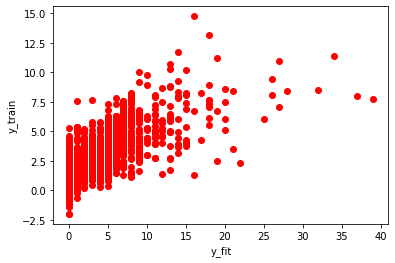

In [ ]:
plt.scatter(y_train, y_fit, c="r", label = "prediction")
plt.ylabel("y_train")
plt.xlabel("y_fit")

Text(0.5, 0, 'y_pred')

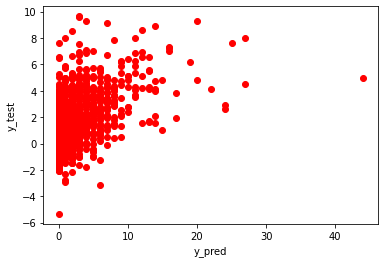

In [ ]:
plt.scatter(y_test, y_pred, c="r", label = "prediction")
plt.ylabel("y_test")
plt.xlabel("y_pred")

In [ ]:
model.evaluate(X_test_norm, y_test)

69/69 [==============================] - 0s 2ms/step - loss: 1.5372 - mae: 1.5372


[1.5372291803359985, 1.5372291803359985]

# Classification

In [ ]:
dataY = gdf_su_new.presence1
dataX = gdf_su_new.drop(["id", "Colamento rapido", "presence1", "presence2",
                         "Aree con crolli/ribaltamenti diffusi",
                         "Aree con frane superficiali diffuse",
                         "Aree con sprofondamenti diffusi", 
                         "Colamento lento",
                         "Colamento rapido", 
                         "Complesso", 
                         "Crollo/Ribaltamento",
                         "Scivolamento rotazionale/traslativo", 
                         "Sprofondamento", "geometry",
                         "n.d."], axis=1)

In [ ]:
dataX_tmp = pd.DataFrame()
for column_name in dataX.columns:
   dataX_tmp[column_name] = dataX[column_name]
   column_transformer = make_column_transformer((StandardScaler(), dataX_tmp.columns))
   X_train, X_test, y_train, y_test = train_test_split(dataX_tmp, dataY, test_size = 0.3, random_state = 42, shuffle = True)
   column_transformer.fit(X_train)
   X_train_normal = column_transformer.transform(X_train)
   X_test_normal = column_transformer.transform(X_test)
   N, D = X_train.shape
   model = tf.keras.models.Sequential([tf.keras.layers.Input(shape=(D,)),
                                    tf.keras.layers.Dense(1, activation="sigmoid")])
   model.compile(optimizer="adam",
             loss = "binary_crossentropy",
             metrics=["accuracy"])
   r = model.fit(X_train_normal, y_train, validation_data=(X_test_normal, y_test), epochs=50, verbose=0)
   print("Model with params:", dataX_tmp.columns)
   print("Train score:", model.evaluate(X_train_normal, y_train))
   print("Test_score:", model.evaluate(X_test_normal, y_test))

   
   

Model with params: Index(['slope_aver'], dtype='object')
161/161 [==============================] - 0s 2ms/step - loss: 0.6893 - accuracy: 0.5163
Train score: [0.6892886161804199, 0.5163043737411499]
69/69 [==============================] - 0s 2ms/step - loss: 0.6892 - accuracy: 0.5163
Test_score: [0.6891923546791077, 0.5163043737411499]
Model with params: Index(['slope_aver', 'slope_stdd'], dtype='object')
161/161 [==============================] - 0s 2ms/step - loss: 0.6880 - accuracy: 0.5378
Train score: [0.6880122423171997, 0.5378493666648865]
69/69 [==============================] - 0s 2ms/step - loss: 0.6889 - accuracy: 0.5285
Test_score: [0.6888613700866699, 0.5285326242446899]
Model with params: Index(['slope_aver', 'slope_stdd', 'pcurv_aver'], dtype='object')
161/161 [==============================] - 0s 2ms/step - loss: 0.6829 - accuracy: 0.5621
Train score: [0.6829328536987305, 0.5621117949485779]
69/69 [==============================] - 0s 2ms/step - loss: 0.6878 - accuracy

In [ ]:
dataX_best = dataX[['slope_aver', 'slope_stdd', 'pcurv_aver', 'pcurv_stdd', 'tcurv_aver',
       'tcurv_stdd', 'nthns_aver', 'nthns_stdd', 'easns_aver', 'easns_stdd',
       'elev_avera', 'elev_stdde', 'twi_averag', 'twi_stddev', 'BDRICM_ave',
       'BDRICM_std', 'BLDFIE_ave', 'BLDFIE_std', 'CLYPPT_ave', 'CLYPPT_std',
       'SLTPPT_ave', 'SLTPPT_std', 'SNDPPT_ave', 'SNDPPT_std', 'Max_Distan',
       'D_sqrt_A', 'area']]
column_transformer = make_column_transformer((StandardScaler(), dataX_best.columns))
X_train, X_test, y_train, y_test = train_test_split(dataX_best, dataY, test_size = 0.3, random_state = 42, shuffle = True)
column_transformer.fit(X_train)
X_train_normal = column_transformer.transform(X_train)
X_test_normal = column_transformer.transform(X_test)
N, D = X_train.shape
model = tf.keras.models.Sequential([tf.keras.layers.Input(shape=(D,)),
                                    tf.keras.layers.Dense(300, activation="relu"),
                                    tf.keras.layers.Dense(100, activation="relu"),
                                    tf.keras.layers.Dense(1, activation="sigmoid")])
model.compile(optimizer="adam",
             loss = "binary_crossentropy",
             metrics=["accuracy"])

In [ ]:
r = model.fit(X_train_normal, y_train, validation_data=(X_test_normal, y_test), epochs=50, verbose=False)
print("Train score:", model.evaluate(X_train_normal, y_train))
print("Test_score:", model.evaluate(X_test_normal, y_test))


161/161 [==============================] - 1s 4ms/step - loss: 0.0235 - accuracy: 0.9988
Train score: [0.02349083684384823, 0.9988353848457336]
69/69 [==============================] - 0s 3ms/step - loss: 1.2677 - accuracy: 0.6857
Test_score: [1.2677475214004517, 0.6856883764266968]


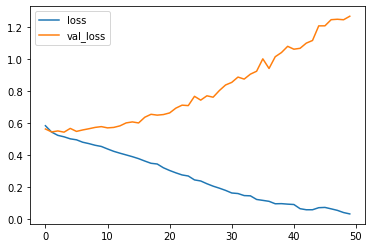

In [ ]:
#plot what's returned by model.fit()
plt.plot(r.history['loss'], label = "loss")
plt.plot(r.history["val_loss"], label = "val_loss")
plt.legend()

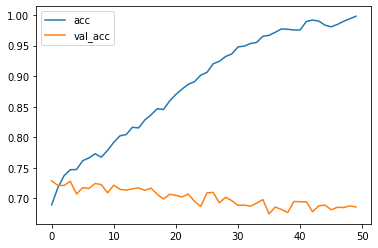

In [ ]:
plt.plot(r.history["accuracy"], label="acc")
plt.plot(r.history["val_accuracy"], label="val_acc")
plt.legend()